In [ ]:
# install from git
!pip install pytorch-lightning python-dotenv wandb boto3 --quiet
!if [ -e ./diffusion_pokemon ]; then rm -rf ./diffusion_pokemon; fi
!git clone --recursive https://github.com/LongDangHoang/DiffusionPokemon ./diffusion_pokemon --quiet  > /dev/null

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 69.5 MB/s eta 0:00:00


In [ ]:
%load_ext autoreload
%autoreload 2

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys

sys.path.append(".")

import math
import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from typing import List, Dict, Optional, Union, Tuple
from pathlib import Path

from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, OneCycleLR

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping, StochasticWeightAveraging, Callback, ModelCheckpoint, LearningRateMonitor

from diffusion_pokemon.side_project_utils.callbacks import *
from diffusion_pokemon.side_project_utils.training_setup import *
from diffusion_pokemon.models.resnet_vae import *

torch.manual_seed(314)
torch.cuda.manual_seed_all(314)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


In [ ]:
# Define hyperparameters
## Define hyperparameters
env = set_os_env_from_notebook_secrets()
project_name = "pokemon-resnet-vae"

config = dict(
    batch_size = 64,
    use_constant_lr = False,
    image_size = 64,
    lr = 1e-5,
    num_epoch = -1,
    overfit_batch = 0,
    weight_decay = 0,
    dropout = 0.1,
    log_wandb = False,
    init_new_wandb_run = False,
    use_existing_run = "hu5wrpvc",
    use_augmentation = True,
    accumulate_grad_batches = 1,
    decoder__num_blocks = 10,
    decoder__num_upsamples = 10,
    decoder__latent_dim = 64,
)


# start a new wandb run to track this script
wandb.login()

if "run" not in globals() and config["log_wandb"]:
    run = wandb.init(
        project=project_name,
        id=config["use_existing_run"] if (config["use_existing_run"] and not config["init_new_wandb_run"]) else None,
        resume="must" if (config["use_existing_run"] and not config["init_new_wandb_run"]) else None,
        config=config,
    )
    assert run is not None

wandb: Currently logged in as: hoanglongdang2001. Use `wandb login --relogin` to force relogin


# Get data

## Pokemon dataset

In [ ]:
from pathlib import Path
import json

if env == "KAGGLE":
    dataset_path = Path("/kaggle/input/pokemon-image-dataset/images")

if env == "COLAB":
    dataset_path = Path('./kaggle/input/pokemon-image-dataset/images')
    Path("/root/.kaggle/").mkdir(parents=True, exist_ok=True)
    with open("/root/.kaggle/kaggle.json", "w") as f:
        json.dump({"username": "danghoanglong", "key": os.getenv("KAGGLE_JSON_KEY")}, f)

    if not dataset_path.exists():
        with open("./kaggle_pokemon_script.sh", "w") as f:
            f.write("""
                mkdir ./kaggle/input/pokemon-image-dataset -p
                kaggle datasets download -d hlrhegemony/pokemon-image-dataset -p ./kaggle/input/pokemon-image-dataset
                unzip -q ./kaggle/input/pokemon-image-dataset/pokemon-image-dataset.zip
                mv images ./kaggle/input/pokemon-image-dataset/
            """)
        os.system("chmod +x ./kaggle_pokemon_script.sh")
        os.system("./kaggle_pokemon_script.sh")

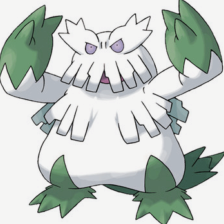

In [ ]:
# data augmentation transforms
data_aug_transforms = [
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
]

# utility transforms
normaliser = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
inv_normaliser = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])
to_pil = transforms.ToPILImage()

# resize transform to control the complexity of the reconstruction loss
resizer = transforms.Resize(config["image_size"], antialias=True)

# load dataset
pokemon_dataset = ImageFolder(
    dataset_path,
    transform=transforms.Compose([
        *(data_aug_transforms if config["use_augmentation"] else []),
        ResNet50_Weights.DEFAULT.transforms()
    ])
)

# visualise
to_pil(inv_normaliser(pokemon_dataset[0][0]))

In [ ]:
# split train valid
pokemon_train_dataset, pokemon_valid_dataset = torch.utils.data.random_split(
    pokemon_dataset,
    [0.8, 0.2],
    generator=torch.Generator().manual_seed(42)
)

print(f"Train: {len(pokemon_train_dataset)}, Valid: {len(pokemon_valid_dataset)}")

pokemon_train_loader = torch.utils.data.DataLoader(
    pokemon_train_dataset,
    batch_size=config["batch_size"],
    shuffle=config["overfit_batch"] is None,
    num_workers=os.cpu_count(),
    pin_memory=True,
)

pokemon_valid_loader = torch.utils.data.DataLoader(
    pokemon_valid_dataset,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=os.cpu_count(),
    pin_memory=True,
)

Train: 2003, Valid: 500


# Init models


In [ ]:
s3_sync_callback = setup_s3_model_checkpointing(
    project_name=project_name,
    wandb_run=run if config["log_wandb"] else None,
    load_from_run=config["use_existing_run"],
    every_n_epochs=300,
)

s3_sync_callback.download_files_from_s3()

Initialised S3 sync. Saving to: pokemon-resnet-vae/local_run/checkpoints and loading from: pokemon-resnet-vae/hu5wrpvc/checkpoints


In [ ]:
model = ResnetVAE(
    latent_space_dim=config["decoder__latent_dim"],
    reconstruction_resize_shape=config["image_size"],
    resnet_ver="resnet50",
    decoder_kwargs={"dropout_rate": config["dropout"], "num_upsamples": config["decoder__num_upsamples"], "num_blocks": config["decoder__num_blocks"], "output_img_size": config["image_size"]}
).to(device)

ckpt_data_dict = torch.load(s3_sync_callback.load_local_dir / "last.ckpt")
model.load_state_dict(ckpt_data_dict["state_dict"])
model.eval()

print("Number of trainable params: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s]


Number of trainable params:  6148638


# Visualise embedding space

In [ ]:
def encode(x, model):
    with torch.no_grad():
        return model.encoder(x)

def embed(x, model):
    with torch.no_grad():
        z = model.encoder(x).reshape((-1, *model.encoder_latent_img_shape))
        mu, log_var = model.mu(z), model.log_var(z)
        return mu, log_var

seed_batch, _ = next(iter(pokemon_valid_loader))
seed_batch = seed_batch.to(device)
encoded_batch = encode(seed_batch, model)
mu, log_var = embed(seed_batch, model)

print("Encoded dims:", encoded_batch.shape)
print("Mu dims:", mu.shape)
print("Log var dims:", log_var.shape)

Encoded dims: torch.Size([64, 100352])
Mu dims: torch.Size([64, 64, 7, 7])
Log var dims: torch.Size([64, 64, 7, 7])


PCA-ed Mu shape: (3136, 3)
Min, max, mean, std, 5th and 95th percentile of each of the principal component:
Dim 0: -8.217972755432129, 9.00209903717041, 3.0410532425584336e-10, 1.1961418390274048, [-1.63340944  1.70249453]
Dim 1: -7.0742974281311035, 7.200953483581543, 7.60263318966281e-09, 0.8762492537498474, [-1.30667043  1.19383785]
Dim 2: -5.611434459686279, 6.613188743591309, -1.2164212970233734e-09, 0.8028672933578491, [-1.11515895  1.16836175]
Mu-RGB shape: (64, 3, 7, 7)


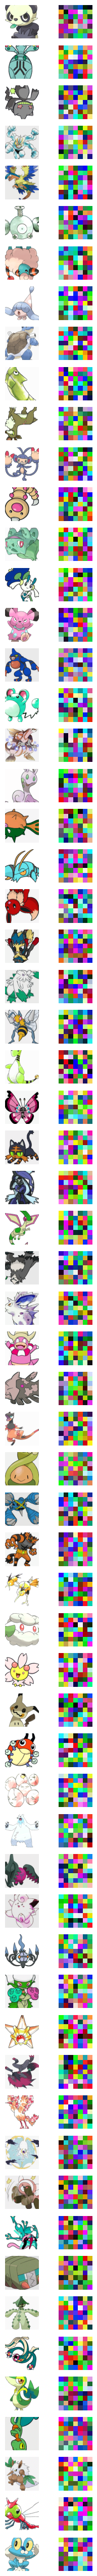

In [ ]:
# pca mu
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

mu_cpu = mu.cpu().numpy()
bs, num_c, w, h = mu_cpu.shape
mu_flat = mu_cpu.reshape((-1, num_c))
mu_transformed = pca.fit_transform(mu_flat)

print("PCA-ed Mu shape:", mu_transformed.shape)
print("Min, max, mean, std, 5th and 95th percentile of each of the principal component:")

for dim in range(3):
    print(f"Dim {dim}: {np.min(mu_transformed[:, dim])}, {np.max(mu_transformed[:, dim])}, {np.mean(mu_transformed[:, dim])}, {np.std(mu_transformed[:, dim])}, {np.quantile(mu_transformed[:, dim], [0.05, 0.95])}")

# mean is 0, std is approximately 1, and percentiles looking like standard normal ish, so we can probably add 1 to the mean and divide everything by 4 (mean 0.5, std 0.25)
# mu_rgb = ((mu_transformed + 1)/4).reshape(bs, 3, w, h)
mu_rgb = mu_transformed.reshape(bs, 3, w, h)
print("Mu-RGB shape:", mu_rgb.shape)


fig, axs = plt.subplots(nrows=bs, ncols=2, figsize=(2.5, bs + 2))
for tensor_img, rgbed_mu, i in zip(seed_batch.cpu(), mu_rgb, range(bs)):
    orig_img = to_pil(inv_normaliser(tensor_img))
    pcaed_mu = to_pil(torch.as_tensor(rgbed_mu))

    axs[i][0].imshow(orig_img)
    axs[i][1].imshow(pcaed_mu)
    axs[i][0].axis(False)
    axs[i][1].axis(False)

plt.show()

PCA-ed encoded shape: (3136, 3)
Min, max, mean, std, 5th and 95th percentile of each of the principal component:
Dim 0: -4.583926677703857, 32.77526092529297, 6.99442281870688e-09, 2.27268385887146, [-1.27262557  1.43631542]
Dim 1: -17.423643112182617, 18.53704261779785, -1.8854530381418044e-08, 2.134395122528076, [-3.48891068  3.07900488]
Dim 2: -3.3875772953033447, 27.13835334777832, -7.298528004184845e-08, 2.0464603900909424, [-2.06793028  3.70704609]
Encoded-RGB shape: (64, 3, 7, 7)


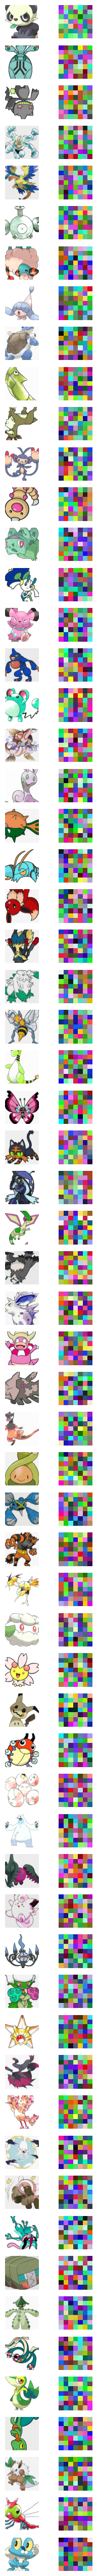

In [ ]:
# makes pca of the the encoded version
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

encoded_cpu = encoded_batch.reshape(-1, *model.encoder_latent_img_shape).cpu().numpy()
bs, num_c, w, h = encoded_cpu.shape
encoded_flat = encoded_cpu.reshape((-1, num_c))
encoded_transformed = pca.fit_transform(encoded_flat)

print("PCA-ed encoded shape:", encoded_transformed.shape)
print("Min, max, mean, std, 5th and 95th percentile of each of the principal component:")

for dim in range(3):
    print(f"Dim {dim}: {np.min(encoded_transformed[:, dim])}, {np.max(encoded_transformed[:, dim])}, {np.mean(encoded_transformed[:, dim])}, {np.std(encoded_transformed[:, dim])}, {np.quantile(encoded_transformed[:, dim], [0.05, 0.95])}")

# mean is 0, std is approximately 1, and percentiles looking like standard normal ish, so we can probably add 1 to the mean and divide everything by 4 (mean 0.5, std 0.25)
# encoded_rgb = ((encoded_transformed + 1)/4).reshape(bs, 3, w, h)
encoded_rgb = encoded_transformed.reshape(bs, 3, w, h)
print("Encoded-RGB shape:", encoded_rgb.shape)


fig, axs = plt.subplots(nrows=bs, ncols=2, figsize=(2.5, bs + 2))
for tensor_img, rgbed_z, i in zip(seed_batch.cpu(), encoded_rgb, range(bs)):
    orig_img = to_pil(inv_normaliser(tensor_img))
    pcaed_encoded = to_pil(torch.as_tensor(rgbed_z))

    axs[i][0].imshow(orig_img)
    axs[i][1].imshow(pcaed_encoded)
    axs[i][0].axis(False)
    axs[i][1].axis(False)

plt.show()

# Experimentation with DINO v2